<center><img src="https://universodiscreto.com/circle-ud.png"/></center>

# Operações Binárias de Imagens e Blending

Nesse notebook serão inseridos exemplos que foram discutidos no vídeo abaixo: 

[<img src="http://i3.ytimg.com/vi/60k962jJAmE/maxresdefault.jpg" width="50%">](https://youtu.be/60k962jJAmE)

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def showImage(img):
    from matplotlib import pyplot as plt
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Soma Binária de Imagens

In [8]:
def showMultipleImageGrid(imgsArray, titlesArray, x, y):
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showImageGrid(imgsArray, titlesArray)
    elif(x == 1):
        fig, axis = plt.subplots(y)
        fig.suptitle(titlesArray)
        yId = 0
        for img in imgsArray:
            imgMPLIB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axis[yId].imshow(imgMPLIB)

            yId += 1
    elif(y == 1):
        fig, axis = plt.subplots(1, x)
        fig.suptitle(titlesArray)
        xId = 0
        for img in imgsArray:
            imgMPLIB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axis[xId].imshow(imgMPLIB)

            xId += 1
    else:
        fig, axis = plt.subplots(y, x)
        xId, yId, titleId = 0, 0, 0
        for img in imgsArray:
            imgMPLIB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axis[yId, xId].set_title(titlesArray[titleId])
            axis[yId, xId].imshow(imgMPLIB)
            if(len(titlesArray[titleId]) == 0):
                axis[yId, xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1

        fig.tight_layout(pad=0.5)
    plt.show()

def plotAddedImages():
    circleImage = cv2.imread("src/bin1.png")
    rectangleImage = cv2.imread("src/bin2.png")
    addedImage = cv2.add(circleImage, rectangleImage)
    addedWeightedImage = cv2.addWeighted(circleImage, 0.9, rectangleImage, 0.1, 0)

    #criando grid com 3 imagens, a segunda com borda replicada e a terceira com borda de espelho
    #a ultima imagem é transparente
    imgsArray = [circleImage, rectangleImage, addedImage, addedWeightedImage]
    titlesArray = ['Círculo', 'Retângulo', 'cv2.add()', 'cv2.addWeighted']
    showMultipleImageGrid(imgsArray, titlesArray, 2, 2)

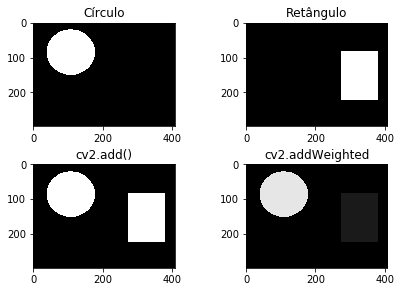

In [9]:
plotAddedImages()

## Transparência (Blending)

In [2]:
def resizeImage(image, scalePercent):
    width = int(image.shape[1] * scalePercent / 100)
    height = int(image.shape[0] * scalePercent / 100)
    image = cv2.resize(image, (width, height))

    return image

def addImageOverlay(background, foreground, translationForegroundW, translationForegroundH):
    backH, backW, _ = background.shape
    foreH, foreW, _ = foreground.shape
    remainingH, remainingW = backH - foreH, backW - foreW

    if translationForegroundH + foreH > backH:
        print("Erro: sobreposição com altura maior do que a permitida.")
        print("Posição final que altura do objeto da frente termina:", translationForegroundH + foreH)
        print("Altura do fundo:", backH)
        return

    if translationForegroundW + foreW > backW:
        print("Erro: sobreposição com largura maior do que a permitida.")
        print("Posição final que largura do objeto da frente termina:", translationForegroundW + foreW)
        print("Largura do fundo:", backW)
        return

    #parte do cenário do fundo em que a imagem será adicionada
    crop = background[translationForegroundH : foreH + translationForegroundH, translationForegroundW : foreW + translationForegroundW]

    #Transformamos o foreground em imagem com tons de cinza e criamos uma máscara binária da mesma com a binarização (cv2.threshold)
    foregroundGray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
    ret, maskFore = cv2.threshold(foregroundGray, 240, 255, cv2.THRESH_BINARY)

    #Agora aplicamos uma operação de AND binário na imagem recortada 'crop'. No caso, realizar a operação binária entre a mesma imagem não terá efeito. Só que, com a inclusão da máscara no terceiro parâmetro, os pixels pretos de maskFore serão ignorados e, portanto, ficarão escuros. Com isso temos a marcação em que vamos incluir o foreground posteriormente.
    backWithMask = cv2.bitwise_and(crop, crop, mask = maskFore)
    foreWithMask = cv2.bitwise_not(maskFore)
    foreWithMask = cv2.bitwise_and(foreground, foreground, mask = foreWithMask)

    #Faremos a composição entre 'frente' e 'fundo', compondo o foreground na imagem extraída do background.
    combinedImage = cv2.add(foreWithMask, backWithMask)

    #Adicionamos a imagem gerada no background final.
    copyImage = background.copy()
    copyImage[translationForegroundH:foreH + translationForegroundH, translationForegroundW:foreW + translationForegroundW] = combinedImage

    return copyImage

def addBlendingEffect(firstImage, secondImage, weight):
    firstImageGray = cv2.cvtColor(firstImage, cv2.COLOR_BGR2GRAY)
    secondImageGray = cv2.cvtColor(secondImage, cv2.COLOR_BGR2GRAY)

    mask = firstImageGray - secondImageGray
    ret, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

    copyImg = firstImage.copy()
    altura, largura, = mask.shape
    for y in range(0, altura):
        for x in range(0, largura):
            if mask.item(y, x) == 255:
                blendingPixelBlue = firstImage.item(y, x, 0) * (1.0 - weight) + secondImage.item(y, x, 0) * weight
                blendingPixelGreen = firstImage.item(y, x, 1) * (1.0 - weight) + secondImage.item(y, x, 1) * weight
                blendingPixelRed = firstImage.item(y, x, 2) * (1.0 - weight) + secondImage.item(y, x, 2) * weight

                copyImg.itemset((y, x, 0), blendingPixelBlue)
                copyImg.itemset((y, x, 1), blendingPixelGreen)
                copyImg.itemset((y, x, 2), blendingPixelRed)

    return copyImg

def memeGeneratorWithBlending(fala1, imagem1, fala2, imagem2, fundo):
    atilaFeliz = cv2.imread(imagem1)
    background = cv2.imread(fundo)
    atilaFeliz = resizeImage(atilaFeliz, 250)
    finalImageUmAtila = addImageOverlay(background, atilaFeliz, 380, 465)

    atilaBravo = cv2.imread(imagem2)
    atilaBravo = resizeImage(atilaBravo, 250)
    finalImageDoisAtilas = addImageOverlay(finalImageUmAtila, atilaBravo, 930, 460)


    finalImage = addBlendingEffect(finalImageUmAtila, finalImageDoisAtilas, 0.4)

    finalImage = cv2.putText(finalImage, fala1, (210, 420), cv2.FONT_HERSHEY_SIMPLEX ,
                   2.5, (0, 0, 0), 5, cv2.LINE_AA)

    finalImage = cv2.putText(finalImage, fala2, (1030, 1150), cv2.FONT_HERSHEY_SIMPLEX ,
                   2.5, (0, 0, 0) , 5, cv2.LINE_AA)

    cv2.imwrite("memeatila.png", finalImage)

memeGeneratorWithBlending('Respeito seu argumento!', "src/atila_feliz.png", 'Burro pra caramba...', "src/atila_bravo.png", "src/fundo2.jpg")

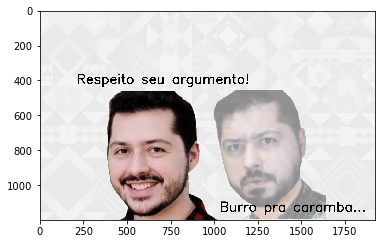

In [4]:
atila_bravo = cv2.imread("memeatila.png")
showImage(atila_bravo)